In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras import optimizers
from keras.models import Model
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [2]:
!cp /content/drive/MyDrive/GitHub/Home/Financial/data_processing.py /content

In [3]:
!cp /content/drive/MyDrive/GitHub/Home/Financial/models.py /content

In [4]:
import data_processing
import models

In [5]:
# load pre-trained GloVe
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-07-28 16:03:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 40s  

2022-07-28 16:05:57 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [6]:
# read csv in as df
inputPath = '/content/drive/MyDrive/GitHub/Home/Financial/Data/pos_expenses_data1.csv'
df = data_processing.load_purchase_attributes(inputPath)
df.head()

,Location,Description,Cost,Category,Day,Month,Year
0,BurgerKing,dinner,2.19,restaurant,15,May,2019
1,Dennys,late night/early morning food for both sam and i,24.76,restaurant,17,May,2019
2,Dennys,tip,4.95,restaurant,17,May,2019
3,Wawa,moving truck fuel,27.50,transportation,17,May,2019
4,Exxon,moving truck fuel,78.25,transportation,17,May,2019


In [7]:
# define data types for columns
new_df_schema = {
'Location': df['Location'].astype(str),
'Description': df['Description'].astype(str),
'Cost': pd.to_numeric(df['Cost']),
'Category': df['Category'].astype(str),
'Day': df['Day'].astype(str),
'Month': df['Month'].astype(str),
'Year': df['Year'].astype(str),
}

# update the data types
df = pd.DataFrame(new_df_schema)

In [8]:
# drop Category and Description data for mlp
X_MLP = df.drop(['Description', 'Category'], axis=1)
# separate Description data for cnn
X_CNN = df['Description']
# set trainY and testY to Category
Y = df['Category']
# get classes from Category
class_names = pd.unique(df['Category'])

In [9]:
# partition the data into training and testing splits using 75% of the data for 
# training and the remaining 25% for testing
split = train_test_split(X_MLP, X_CNN, Y, test_size=0.25, random_state=42)
(trainX_MLP, testX_MLP, trainX_CNN, testX_CNN, trainY, testY) = split
# process the purchase attributes data by performing min-max scaling on
# continuous features, one-hot encoding on categorical features, and then
# finally concatenating them together
(trainX_MLP, testX_MLP) = data_processing.process_purchase_attributes(X_MLP, trainX_MLP, testX_MLP)
X = data_processing.process_purchase_attributes_all(X_MLP)
# one-hot encode Y
Y = np.array(Y).reshape(-1, 1)
trainY = np.array(trainY).reshape(-1, 1)
testY = np.array(testY).reshape(-1, 1)
(trainY, testY) = data_processing.process_purchase_labels(Y, trainY, testY)

In [10]:
# process Description data and create embedding layer for cnn
voc, word_index, vectorizer = data_processing.create_vocab_index(trainX_CNN)
embeddings_index = data_processing.create_embeddings_index()
num_tokens, embedding_dim, embedding_matrix = data_processing.create_embedding_matrix(
    voc, word_index, embeddings_index)

In [11]:
# vectorize cnn input
trainX_CNN = vectorizer(np.array([[s] for s in trainX_CNN])).numpy()
testX_CNN = vectorizer(np.array([[s] for s in testX_CNN])).numpy()

In [12]:
# create the MLP and CNN models
mlp = models.create_mlp_multi(trainX_MLP.shape[1])
cnn = models.create_cnn_multi(num_tokens, embedding_dim, embedding_matrix, class_names, 128)
# create the combined model
model = models.create_multi(mlp, cnn, class_names)

In [13]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                14880     
                                                                 
Total params: 14,880
Trainable params: 14,880
Non-trainable params: 0
_________________________________________________________________


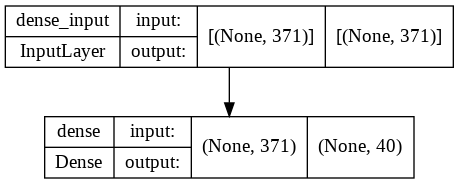

In [14]:
plot_model(mlp, to_file='mlp_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         86600     
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

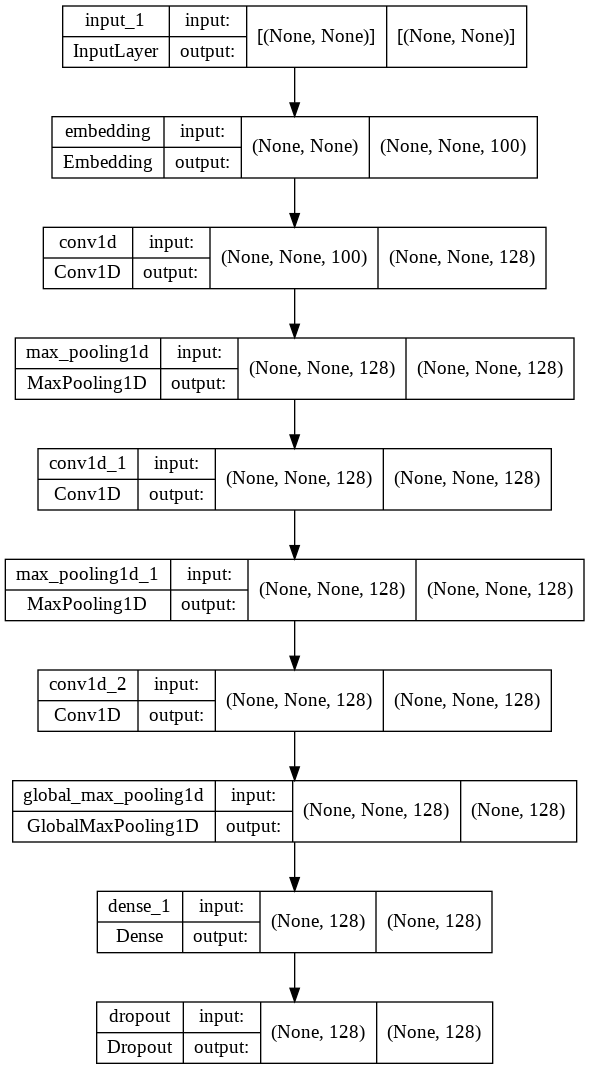

In [16]:
plot_model(cnn, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    86600       ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, None, 128)    64128       ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, None, 128)    0           ['conv1d[0][0]']                 
                                                                                            

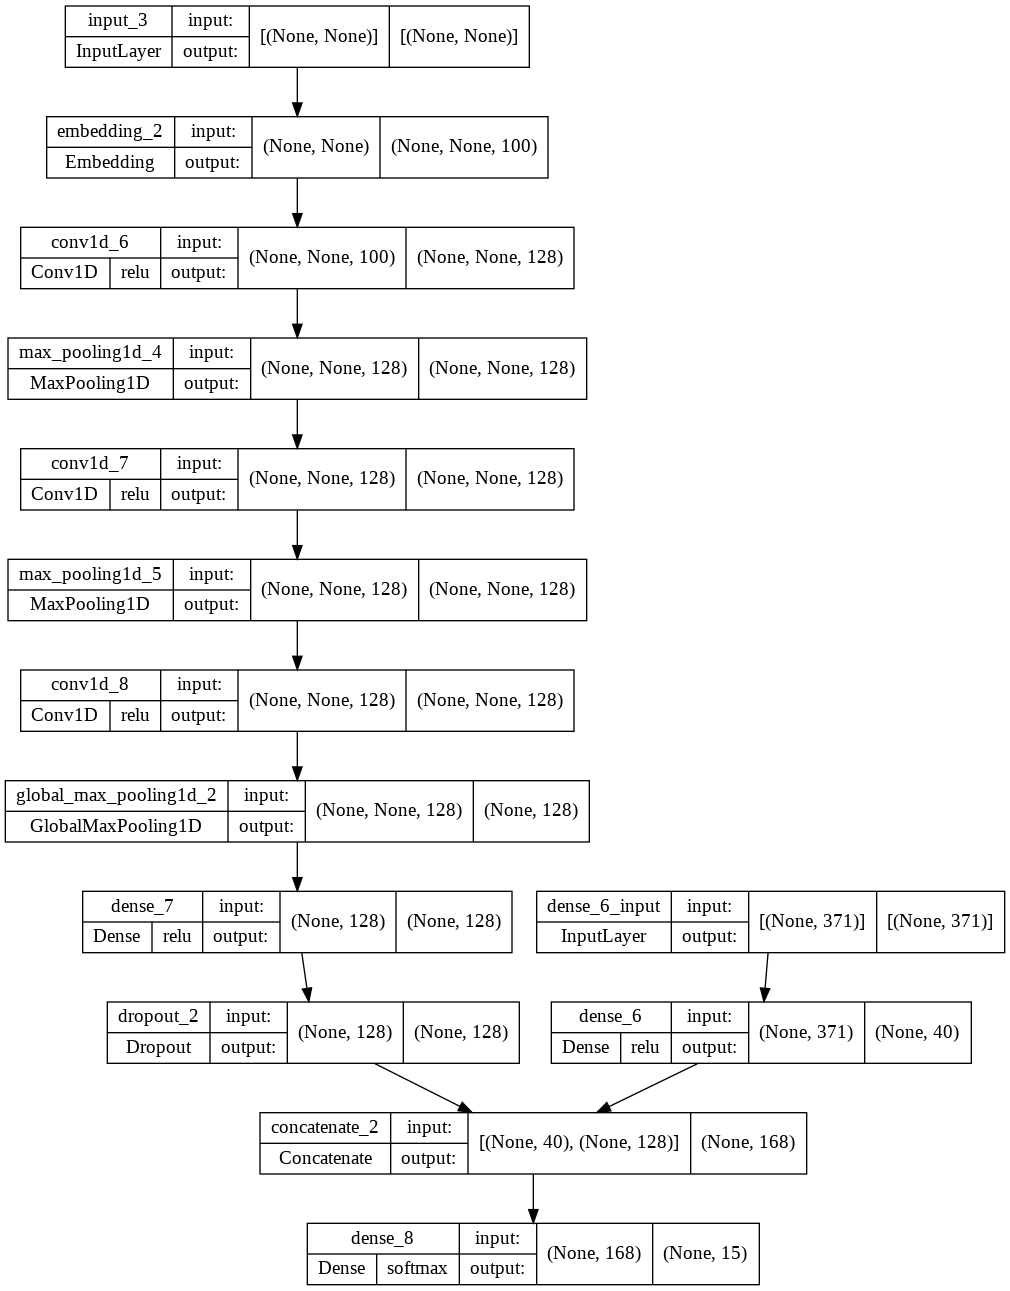

In [69]:
# plot the combined model
plot_model(model, to_file='combined-model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [24]:
# create the MLP and CNN models
mlp = models.create_mlp_multi(trainX_MLP.shape[1])
cnn = models.create_cnn_multi(num_tokens, embedding_dim, embedding_matrix, class_names, 128)
# create the combined model
model = models.create_multi(mlp, cnn, class_names)

In [25]:
# compile the model using categorical crossentropy loss
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
# train the model
history = model.fit(
	x=[trainX_MLP, trainX_CNN], y=trainY,
	validation_data=([testX_MLP, testX_CNN], testY),
	epochs=10, batch_size=16)
# make predictions on the testing data
preds = model.predict([testX_MLP, testX_CNN])

Epoch 1/10
134/134 [==============================] - 7s 44ms/step - loss: 1.2347 - acc: 0.6576 - val_loss: 0.8438 - val_acc: 0.7634
Epoch 2/10
134/134 [==============================] - 6s 44ms/step - loss: 0.7254 - acc: 0.7839 - val_loss: 0.5985 - val_acc: 0.8225
Epoch 3/10
134/134 [==============================] - 6s 44ms/step - loss: 0.5008 - acc: 0.8572 - val_loss: 0.5361 - val_acc: 0.8423
Epoch 4/10
134/134 [==============================] - 6s 43ms/step - loss: 0.3688 - acc: 0.8990 - val_loss: 0.4300 - val_acc: 0.8859
Epoch 5/10
134/134 [==============================] - 5s 40ms/step - loss: 0.2736 - acc: 0.9258 - val_loss: 0.4216 - val_acc: 0.9000
Epoch 6/10
134/134 [==============================] - 5s 40ms/step - loss: 0.2242 - acc: 0.9389 - val_loss: 0.3868 - val_acc: 0.9085
Epoch 7/10
134/134 [==============================] - 5s 41ms/step - loss: 0.1602 - acc: 0.9554 - val_loss: 0.3905 - val_acc: 0.9056
Epoch 8/10
134/134 [==============================] - 5s 40ms/step - 

epochs=10, batch_size=16
Test loss: 0.3881075978279114
Test accuracy: 0.9140844941139221


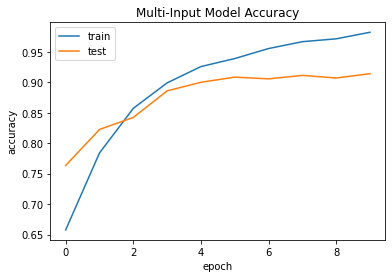

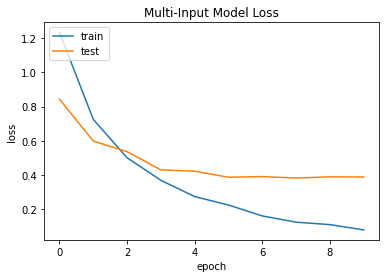

In [26]:
# print loss and accuracy, then plot
print('epochs=10, batch_size=16')
score = model.evaluate([testX_MLP, testX_CNN], testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Multi-Input Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Multi-Input Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
model.save("multi_input_model")

INFO:tensorflow:Assets written to: multi_input_model/assets


INFO:tensorflow:Assets written to: multi_input_model/assets


In [59]:
# display results
preds = model.predict([testX_MLP, testX_CNN])
pred_df = pd.DataFrame(preds, columns = ['alcohol', 'business',	'clothes',	'education',	'entertainment',	'grocery',	'health', 'hygiene', 'improvement',	'misc',	'rent',	'restaurant',	'supplies',	'transportation',	'utilities'])
pred_df = pred_df.idxmax(axis=1)

label_df = pd.DataFrame(testY, columns = ['alcohol', 'business',	'clothes',	'education',	'entertainment',	'grocery',	'health',	'hygiene', 'improvement',	'misc',	'rent',	'restaurant',	'supplies',	'transportation',	'utilities'])
label_df = label_df.idxmax(axis=1)

split = train_test_split(X_MLP, X_CNN, test_size=0.25, random_state=42)
(train_MLP, test_MLP, train_CNN, test_CNN) = split

testCNN_df = pd.DataFrame(test_CNN).reset_index(drop=True)
testMLP_df = pd.DataFrame(test_MLP).reset_index(drop=True)
  
compare_df = pd.concat([testMLP_df, testCNN_df, pred_df, label_df], axis=1)
compare_df.columns =['Location', 'Cost', 'Day', 'Month', 'Year', 'Description', 'Predicted', 'Actual']

In [60]:
cols=['Year','Month','Day']
compare_df['Date'] = compare_df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
compare_df['Date']=pd.to_datetime(compare_df['Date'])
compare_df = compare_df.drop(['Year','Month','Day'], axis=1)
compare_df = compare_df[['Location', 'Date', 'Description', 'Cost', 'Predicted', 'Actual']]
compare_df

,Location,Date,Description,Cost,Predicted,Actual
0,e'sbar,2019-08-23,beer,8.00,restaurant,restaurant
1,BayonneBBQ&Wings,2020-05-01,dinner,36.60,restaurant,restaurant
2,MadisonParking,2021-08-10,parking,2.75,entertainment,transportation
3,WholeFoods,2020-05-12,bread 8-grain,2.99,grocery,grocery
4,FoodLion,2020-09-03,tax,0.74,misc,misc
...,...,...,...,...,...,...
705,RiteAid,2019-09-01,mouthwash,6.29,grocery,hygiene
706,Walmart,2020-10-24,tortilla chips,2.98,grocery,grocery
707,Walmart,2020-05-11,alfredo,7.08,grocery,grocery
708,GraceCoffee,2021-08-05,coffee and croissant,12.05,restaurant,restaurant


In [ ]:
def highlight(row):

    if row['Predicted'] != row['Actual']:
        color = 'yellow'
    elif row['Predicted'] == row['Actual']:
        color = 'white'

    background = ['background-color: {}'.format(color) for _ in row]

    return background

compare_df.style.apply(highlight, axis=1)

In [65]:
compare_df.to_excel('predictions_data.xlsx', index=False)
compare_df

,Location,Date,Description,Cost,Predicted,Actual
0,e'sbar,2019-08-23,beer,8.00,restaurant,restaurant
1,BayonneBBQ&Wings,2020-05-01,dinner,36.60,restaurant,restaurant
2,MadisonParking,2021-08-10,parking,2.75,entertainment,transportation
3,WholeFoods,2020-05-12,bread 8-grain,2.99,grocery,grocery
4,FoodLion,2020-09-03,tax,0.74,misc,misc
...,...,...,...,...,...,...
705,RiteAid,2019-09-01,mouthwash,6.29,grocery,hygiene
706,Walmart,2020-10-24,tortilla chips,2.98,grocery,grocery
707,Walmart,2020-05-11,alfredo,7.08,grocery,grocery
708,GraceCoffee,2021-08-05,coffee and croissant,12.05,restaurant,restaurant


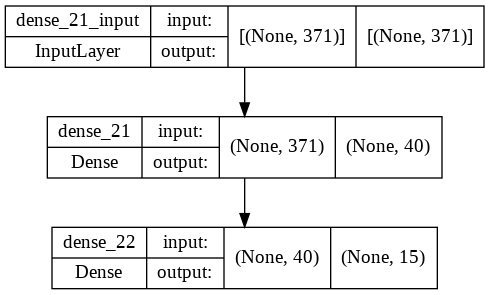

In [75]:
# create the MLP and CNN models
mlp1 = models.create_mlp(trainX_MLP.shape[1], class_names)
plot_model(mlp1, to_file='mlp_plot.png', show_shapes=True, show_layer_names=True)

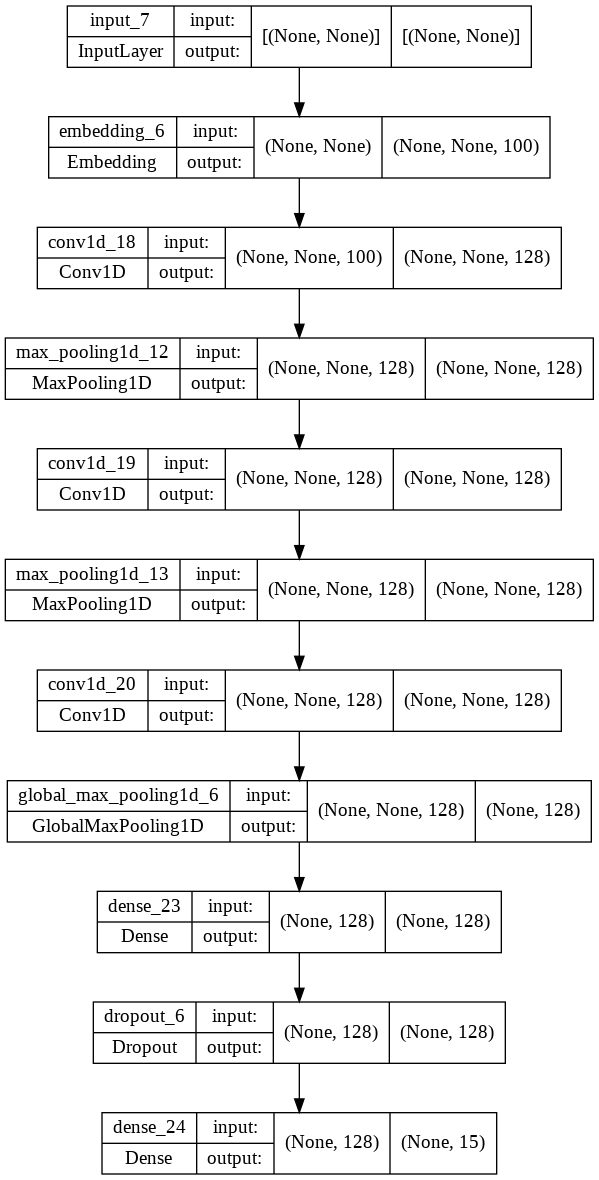

In [76]:
cnn1 = models.create_cnn(num_tokens, embedding_dim, embedding_matrix, class_names, 128)
plot_model(cnn1, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [77]:
# compile the model using categorical crossentropy loss
mlp1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
# train the model
mlp1_history = mlp1.fit(
	x=trainX_MLP, y=trainY,
	validation_data=(testX_MLP, testY),
	epochs=10, batch_size=16)
# make predictions on the testing data
preds = mlp1.predict(testX_MLP)

Epoch 1/10
134/134 [==============================] - 1s 4ms/step - loss: 2.1490 - acc: 0.4537 - val_loss: 1.5894 - val_acc: 0.5310
Epoch 2/10
134/134 [==============================] - 0s 3ms/step - loss: 1.5162 - acc: 0.5190 - val_loss: 1.4182 - val_acc: 0.5394
Epoch 3/10
134/134 [==============================] - 0s 3ms/step - loss: 1.3386 - acc: 0.5721 - val_loss: 1.2762 - val_acc: 0.6225
Epoch 4/10
134/134 [==============================] - 0s 3ms/step - loss: 1.1849 - acc: 0.6538 - val_loss: 1.1598 - val_acc: 0.6789
Epoch 5/10
134/134 [==============================] - 0s 3ms/step - loss: 1.0631 - acc: 0.7022 - val_loss: 1.0748 - val_acc: 0.7042
Epoch 6/10
134/134 [==============================] - 1s 4ms/step - loss: 0.9656 - acc: 0.7370 - val_loss: 1.0102 - val_acc: 0.7211
Epoch 7/10
134/134 [==============================] - 0s 4ms/step - loss: 0.8822 - acc: 0.7656 - val_loss: 0.9575 - val_acc: 0.7296
Epoch 8/10
134/134 [==============================] - 0s 3ms/step - loss: 0.

In [78]:
# compile the model using categorical crossentropy loss
cnn1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
# train the model
cnn1_history = cnn1.fit(
	x=trainX_CNN, y=trainY,
	validation_data=(testX_CNN, testY),
	epochs=10, batch_size=16)
# make predictions on the testing data
preds = cnn1.predict(testX_CNN)

Epoch 1/10
134/134 [==============================] - 7s 41ms/step - loss: 1.2652 - acc: 0.6379 - val_loss: 0.8780 - val_acc: 0.7338
Epoch 2/10
134/134 [==============================] - 5s 40ms/step - loss: 0.7736 - acc: 0.7661 - val_loss: 0.6855 - val_acc: 0.7775
Epoch 3/10
134/134 [==============================] - 8s 57ms/step - loss: 0.5902 - acc: 0.8243 - val_loss: 0.5803 - val_acc: 0.8282
Epoch 4/10
134/134 [==============================] - 8s 61ms/step - loss: 0.4683 - acc: 0.8577 - val_loss: 0.5257 - val_acc: 0.8296
Epoch 5/10
134/134 [==============================] - 7s 53ms/step - loss: 0.3696 - acc: 0.8934 - val_loss: 0.5048 - val_acc: 0.8761
Epoch 6/10
134/134 [==============================] - 5s 40ms/step - loss: 0.3084 - acc: 0.9122 - val_loss: 0.5090 - val_acc: 0.8606
Epoch 7/10
134/134 [==============================] - 5s 40ms/step - loss: 0.2527 - acc: 0.9291 - val_loss: 0.5126 - val_acc: 0.8704
Epoch 8/10
134/134 [==============================] - 5s 39ms/step - 

In [98]:
model_list = ['MLP', 'CNN', 'Multi-Input']
acc_list = []
loss_list = []

mlp_score = mlp1.evaluate([testX_MLP], testY, verbose=0)
cnn_score = cnn1.evaluate([testX_CNN], testY, verbose=0)
multi_input_score = model.evaluate([testX_MLP, testX_CNN], testY, verbose=0)

acc_list.append(mlp_score[1]*100)
acc_list.append(cnn_score[1]*100)
acc_list.append(multi_input_score[1]*100)

loss_list.append(mlp_score[0])
loss_list.append(cnn_score[0])
loss_list.append(multi_input_score[0])

result_df = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'Loss': loss_list}).round(4)
result_df['Accuracy'] = result_df['Accuracy'].astype(str) + '%'
result_df

,Model,Accuracy,Loss
0,MLP,73.8028%,0.8753
1,CNN,88.0282%,0.5020
2,Multi-Input,91.4084%,0.3881
